### Load required packages

In [1]:
import os
import warnings
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")

pwd = os.getcwd()

Global seed set to 0


### Load and prepare data

In [2]:
# Load the RNAseq, ATACseq, and multiome datasets separately
# See https://docs.scvi-tools.org/en/stable/tutorials/notebooks/MultiVI_tutorial.html for requirements
adata_rna = sc.read_h5ad('/allen/programs/celltypes/workgroups/hct/SEA-AD/RNAseq/scANVI/output/MTG_AD/objects/All_scANVI.2022-02-16.h5ad')
# probably a good place to start to get a sense of what you need to subset.
adata_rna.obs.groupby(["studies", "method"]).size()

studies                           method  
10xValidation                     10Xv3         12585
                                  10Xv3.1           0
                                  10xMulti          0
AD_Center_Grant                   10Xv3             0
                                  10Xv3.1     1051158
                                  10xMulti          0
AD_Center_Grant, AD_Mult_Cohort   10Xv3             0
                                  10Xv3.1       91387
                                  10xMulti      51787
AD_Center_Grant, AD_Mult_Cohort2  10Xv3             0
                                  10Xv3.1       84735
                                  10xMulti      28645
AD_Center_Grant, AD_Mult_Cohort3  10Xv3             0
                                  10Xv3.1       88004
                                  10xMulti      29445
AD_Mult_Cohort2, AD_Center_Grant  10Xv3             0
                                  10Xv3.1       75785
                                  10xMu

In [3]:
cohorts = ["AD_Center_Grant, AD_Mult_Cohort", "AD_Center_Grant, AD_Mult_Cohort2", "AD_Center_Grant, AD_Mult_Cohort3", "AD_Mult_Cohort2, AD_Center_Grant", "AD_Mult_Cohort3, AD_Center_Grant", "AD_Mult_Cohort, AD_Center_Grant"]
adata_rna_sub = adata_rna[[i in cohorts for i in adata_rna.obs["studies"]]].copy()

In [4]:
adata_rna_sub.shape

(764422, 36601)

In [6]:
adata_rna_sub.write(filename="AD_3cohorts_RNA_and_MultiomeRNA_anndata.h5ad")

In [7]:
del adata_rna

In [8]:
## get multiome-RNA data for 3 cohorts.
adata_mult_rna = adata_rna_sub[[i in ["10xMulti"] for i in adata_rna_sub.obs["method"]]].copy()

In [10]:
adata_mult_rna.shape

(262261, 36601)

In [11]:
adata_mult_rna.write(filename="AD_3cohorts_MultiomeRNA_anndata.h5ad")

In [12]:
del adata_rna_sub

### Load prepared data if above steps have been done

In [2]:
adata_mult_rna = anndata.read_h5ad(filename="AD_3cohorts_MultiomeRNA_anndata.h5ad")

In [3]:
adata_mult_rna.var["modality"] = "Gene Expression"
adata_mult_rna.var

,gene_ids,modality
MIR1302-2HG,MIR1302-2HG,Gene Expression
FAM138A,FAM138A,Gene Expression
OR4F5,OR4F5,Gene Expression
AL627309.1,AL627309.1,Gene Expression
AL627309.3,AL627309.3,Gene Expression
...,...,...
AC141272.1,AC141272.1,Gene Expression
AC023491.2,AC023491.2,Gene Expression
AC007325.1,AC007325.1,Gene Expression
AC007325.4,AC007325.4,Gene Expression


In [4]:
library_prep_ar_id = adata_mult_rna.obs['library_prep'].astype(str) + "-" + adata_mult_rna.obs['ar_id'].astype(str)
library_prep_ar_id = library_prep_ar_id.unique()
print(library_prep_ar_id.shape)
print(library_prep_ar_id)

(28,)
['L8XR_210812_01_E11-1126220036' 'L8XR_210930_02_C03-1135448412'
 'L8XR_210722_01_D08-1122543703' 'L8XR_210729_01_E09-1122543707'
 'L8XR_211014_02_D05-1136687625' 'L8XR_211007_02_C04-1135704089'
 'L8XR_211014_02_H05-1136687627' 'L8XR_211007_02_G03-1135704088'
 'L8XR_210722_01_B08-1122543704' 'L8XR_210805_01_E10-1124629229'
 'L8XR_210715_01_A12-1121939868' 'L8XR_210812_01_F11-1124987484'
 'L8XR_211007_02_F03-1135448413' 'L8XR_210902_02_B08-1131257169'
 'L8XR_210722_01_H07-1122543705' 'L8XR_210812_01_A12-1124987483'
 'L8XR_211021_02_G06-1138433804' 'L8XR_210916_02_B11-1131607954'
 'L8XR_210812_01_D11-1124987482' 'L8XR_210715_01_E12-1121747487'
 'L8XR_210729_01_C09-1122543708' 'L8XR_210805_01_H09-1124629228'
 'L8XR_210729_01_B09-1122543706' 'L8XR_210715_01_D12-1121747486'
 'L8XR_210729_01_D09-1124629224' 'L8XR_210902_02_D08-1131257170'
 'L8XR_210826_01_G03-1129238386' 'L8XR_211021_02_E08-1138433803']


In [2]:
# Preprocess and load the ATAC datasets from singleome or multiome.
def create_atac_anndata(base_path, library_prep_ar_id, mtx_ext, peak_ext, barcode_ext):
    adata = anndata.read_mtx(os.path.join(base_path, library_prep_ar_id + mtx_ext))
    coords = pd.read_csv(
        os.path.join(base_path, library_prep_ar_id + peak_ext),
        sep="\t",
        header=None,
        index_col=None,
    )
    coords.rename({0: "chr", 1: "start", 2: "end"}, axis="columns", inplace=True)
    coords.set_index(
        coords.chr.astype(str)
        + ":"
        + coords.start.astype(str)
        + "-"
        + coords.end.astype(str),
        inplace=True,
    )
    coords.index = coords.index.astype(str)
    
    cell_annot = pd.read_csv(
        os.path.join(base_path, library_prep_ar_id + barcode_ext), 
        sep="-", 
        header=None, 
        index_col=None
    )
    cell_annot.rename({0: "barcode", 1: "batch_id"}, axis="columns", inplace=True)
    cell_annot["library_prep"] = library_prep_ar_id.split("-")[0]
    # cell_annot["ar_id"] = library_prep_ar_id.split("-")[1]
    cell_annot["sample_id"] = cell_annot["barcode"] + "-" + library_prep_ar_id
    cell_annot["barcode"] = cell_annot["barcode"] + "-" + cell_annot["library_prep"]
    cell_annot.set_index("barcode", inplace=True)
    cell_annot.index = cell_annot.index.astype(str)
    
    adata.obs = cell_annot
    # adata.obs["modality"] = "accessibility"
    adata.var = coords
    adata.var["modality"] = "Peaks"
    return adata.copy()


In [8]:
# Preprocess and merge multiome-rna and multiome-atac datasets.
base_path = "/allen/programs/celltypes/workgroups/hct/SEA-AD/ATACseq/Human_AD_MTG_peakCounts/multiome_ATAC/"
mtx_ext = ".multiome.atac.tsv_grps13-6.merged_counts.mtx"
peak_ext = ".multiome.atac.tsv_grps13-6.merged_peaks.bed"
barcode_ext = ".multiome.atac.tsv_grps13-6.merged_barcodes.tsv"
adata_mult_atac_list = []

for lib in library_prep_ar_id:
    adata_atac = create_atac_anndata(base_path, lib, mtx_ext, peak_ext, barcode_ext)
    adata_mult_atac_list.append(adata_atac)

adata_mult_atac = anndata.concat(adata_mult_atac_list, merge = "same")

In [9]:
del adata_mult_atac_list
adata_mult_atac

AnnData object with n_obs × n_vars = 281382 × 330348
    obs: 'batch_id', 'library_prep', 'sample_id'
    var: 'chr', 'start', 'end', 'modality'

In [10]:
adata_mult_atac.write(filename="AD_3cohorts_MultiomeATAC_anndata.h5ad")

... storing 'library_prep' as categorical
... storing 'chr' as categorical
... storing 'modality' as categorical


In [4]:
adata_mult_atac = anndata.read_h5ad(filename="AD_3cohorts_MultiomeATAC_anndata.h5ad")

In [5]:
adata_mult_atac.var

,chr,start,end,modality
chr1:10153-10217,chr1,10153,10217,Peaks
chr1:17456-17520,chr1,17456,17520,Peaks
chr1:180742-181572,chr1,180742,181572,Peaks
chr1:184441-184510,chr1,184441,184510,Peaks
chr1:187057-187095,chr1,187057,187095,Peaks
...,...,...,...,...
chrY:56876016-56876220,chrY,56876016,56876220,Peaks
chrY:56877542-56877970,chrY,56877542,56877970,Peaks
chrY:56878751-56878789,chrY,56878751,56878789,Peaks
chrY:56879564-56880570,chrY,56879564,56880570,Peaks


In [6]:
cells = np.intersect1d(adata_mult_rna.obs.index, adata_mult_atac.obs.index, assume_unique=True)

In [7]:
adata_mult_atac = adata_mult_atac[cells, :].copy()
adata_mult_rna = adata_mult_rna[cells, :].copy()

In [8]:
adata_mult_rna = adata_mult_rna[adata_mult_rna.obs.index.argsort(), :].copy()
adata_mult_atac = adata_mult_atac[adata_mult_atac.obs.index.argsort(), :].copy()

In [9]:
sum(adata_mult_atac.obs.index != adata_mult_rna.obs.index)

0

In [10]:
adata_mult = anndata.concat([adata_mult_rna, adata_mult_atac], axis=1, join="inner", merge="unique")

In [11]:
adata_mult.var

,modality
MIR1302-2HG,Gene Expression
FAM138A,Gene Expression
OR4F5,Gene Expression
AL627309.1,Gene Expression
AL627309.3,Gene Expression
...,...
chrY:56876016-56876220,Peaks
chrY:56877542-56877970,Peaks
chrY:56878751-56878789,Peaks
chrY:56879564-56880570,Peaks


In [12]:
np.setdiff1d(adata_mult.obs.columns, adata_mult_rna.obs.columns, assume_unique=True)

array(['batch_id'], dtype=object)

In [13]:
np.setdiff1d(adata_mult_rna.obs.columns, adata_mult.obs.columns, assume_unique=True)

array([], dtype=object)

In [14]:
adata_mult.write(filename="AD_3cohorts_MultiomeATACRNA_anndata.h5ad")

... storing 'modality' as categorical


In [15]:
print(adata_mult.shape)
print(adata_mult_rna.shape)
print(adata_mult_atac.shape)

(262261, 366949)
(262261, 36601)
(262261, 330348)


In [16]:
del adata_mult_atac
del adata_mult_rna

### Prepare singleome ATAC anndata

In [3]:
base_path = "/allen/programs/celltypes/workgroups/hct/SEA-AD/ATACseq/Human_AD_MTG_peakCounts/singleome_ATAC/"
mtx_ext = ".tsv_grps13-6.merged_counts.mtx"
peak_ext = ".tsv_grps13-6.merged_peaks.bed"
barcode_ext = ".tsv_grps13-6.merged_barcodes.tsv"
adata_atac_list = []

In [4]:
file_names = [fn for fn in os.listdir(base_path) if fn.endswith(mtx_ext)]
print(file_names[:3])
print("there are " + str(len(file_names)) + " libraries in this folder")
library_prep_ar_id = [lib.split(mtx_ext)[0] for lib in file_names]
del file_names

['L8AT_210916_01_B08-1131409693.tsv_grps13-6.merged_counts.mtx', 'L8AT_211108_01_H01-1142581755.tsv_grps13-6.merged_counts.mtx', 'L8AT_211018_01_B03-1138433801.tsv_grps13-6.merged_counts.mtx']
there are 102 libraries in this folder


In [5]:
for lib in library_prep_ar_id:
    adata_atac = create_atac_anndata(base_path, lib, mtx_ext, peak_ext, barcode_ext)
    adata_atac_list.append(adata_atac)

adata_atac_only = anndata.concat(adata_atac_list, merge = "same")
del adata_atac_list

In [6]:
adata_atac_only.write(filename="AD_complete_ATAC_only_anndata.h5ad")
adata_atac_only

... storing 'library_prep' as categorical
... storing 'chr' as categorical
... storing 'modality' as categorical


AnnData object with n_obs × n_vars = 867401 × 330348
    obs: 'batch_id', 'library_prep', 'sample_id'
    var: 'chr', 'start', 'end', 'modality'

### Prepare MVI datasets and run MultiVI

In [17]:
## reload dataset if necessary
adata_atac_only = anndata.read_h5ad(filename="AD_complete_ATAC_only_anndata.h5ad")

In [18]:
# add meta info for singleome ATAC datasets to avoid NAN in the model training.
atac_only_anno = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/ATAC-Seq/Arrow/ATAC_AD_Center_Grant_complete/ATAC_AD_Center_Grant_complete.csv")
atac_only_anno = atac_only_anno.loc[:, ['age', 'sex', 'medical_conditions', 'donor_name', 'method', 'library_prep']]
atac_only_anno['sex'] = np.where(atac_only_anno['sex'] == 'M', 'Male', 'Female')
atac_only_anno['sex'] = atac_only_anno['sex'].astype('category')
atac_only_anno

,age,sex,medical_conditions,donor_name,method,library_prep
0,85 yrs,Female,AD neuropathological change = 2 (intermediate)...,H20.33.034,10xATAC_v1.1,L8AT_211117_01_G07
1,99 yrs,Female,AD neuropathological change = 0 (none)_and_APO...,H20.33.035,10xATAC_v1.1,L8AT_211117_01_H07
2,90 yrs,Female,AD neuropathological change = 3 (high)_and_APO...,H20.33.036,10xATAC_v1.1,L8AT_211117_01_A08
3,96 yrs,Female,AD neuropathological change = 3 (high)_and_APO...,H20.33.037,10xATAC_v1.1,L8AT_211117_01_B08
4,85 yrs,Male,AD neuropathological change = 2 (intermediate)...,H20.33.043,10xATAC_v1.1,L8AT_211117_01_C08
...,...,...,...,...,...,...
97,58 yrs,Male,NaN,H19.30.004,10xATAC_v1.1,L8AT_210427_01_B05
98,94 yrs,Female,NaN,H21.33.045,10xATAC_v1.1,L8AT_220126_01_B09
99,97 yrs,Male,NaN,H21.33.046,10xATAC_v1.1,L8AT_220126_01_C09
100,90 yrs,Female,NaN,H21.33.047,10xATAC_v1.1,L8AT_220126_01_D09


In [19]:
df = adata_atac_only.obs
df

,batch_id,library_prep,sample_id
barcode,,,
AAACGAAAGACTAGGC-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGACTAGGC-L8AT_210916_01_B08-1131409693
AAACGAAAGATCGCCC-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGATCGCCC-L8AT_210916_01_B08-1131409693
AAACGAAAGGCAGTGT-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGGCAGTGT-L8AT_210916_01_B08-1131409693
AAACGAAAGGCCTCGT-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGGCCTCGT-L8AT_210916_01_B08-1131409693
AAACGAAAGTATACGA-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGTATACGA-L8AT_210916_01_B08-1131409693
...,...,...,...
TTTGTGTGTGCGCATC-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTGCGCATC-L8AT_211117_01_F07-1144788667
TTTGTGTGTTACCCAA-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTTACCCAA-L8AT_211117_01_F07-1144788667
TTTGTGTGTTTGACCA-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTTTGACCA-L8AT_211117_01_F07-1144788667


In [20]:
df.reset_index(inplace=True)
print("original ATAC only observation shape: ", df.shape)
df_new = pd.merge(df, atac_only_anno, how='left', on='library_prep')
print("joined dataframe shape: ", df_new.shape)

# to test if left join keeps original left df order.
print("barcode order that matches between original and joined dataframes: ", sum(df_new.barcode == df.barcode))

adata_atac_only.obs = df_new
adata_atac_only.obs.set_index("barcode", inplace=True)
print("ATAC only observation shape: ", adata_atac_only.obs.shape)

adata_atac_only.obs

original ATAC only observation shape:  (867401, 4)
joined dataframe shape:  (867401, 9)
barcode order that matches between original and joined dataframes:  867401
ATAC only observation shape:  (867401, 8)


,batch_id,library_prep,sample_id,age,sex,medical_conditions,donor_name,method
barcode,,,,,,,,
AAACGAAAGACTAGGC-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGACTAGGC-L8AT_210916_01_B08-1131409693,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,H21.33.003,10xATAC_v1.1
AAACGAAAGATCGCCC-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGATCGCCC-L8AT_210916_01_B08-1131409693,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,H21.33.003,10xATAC_v1.1
AAACGAAAGGCAGTGT-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGGCAGTGT-L8AT_210916_01_B08-1131409693,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,H21.33.003,10xATAC_v1.1
AAACGAAAGGCCTCGT-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGGCCTCGT-L8AT_210916_01_B08-1131409693,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,H21.33.003,10xATAC_v1.1
AAACGAAAGTATACGA-L8AT_210916_01_B08,1,L8AT_210916_01_B08,AAACGAAAGTATACGA-L8AT_210916_01_B08-1131409693,78 yrs,Male,AD neuropathological change = 0 (none)_and_APO...,H21.33.003,10xATAC_v1.1
...,...,...,...,...,...,...,...,...
TTTGTGTGTGCGCATC-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTGCGCATC-L8AT_211117_01_F07-1144788667,68 yrs,Male,AD neuropathological change = 3 (high)_and_APO...,H20.33.033,10xATAC_v1.1
TTTGTGTGTTACCCAA-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTTACCCAA-L8AT_211117_01_F07-1144788667,68 yrs,Male,AD neuropathological change = 3 (high)_and_APO...,H20.33.033,10xATAC_v1.1
TTTGTGTGTTTGACCA-L8AT_211117_01_F07,1,L8AT_211117_01_F07,TTTGTGTGTTTGACCA-L8AT_211117_01_F07-1144788667,68 yrs,Male,AD neuropathological change = 3 (high)_and_APO...,H20.33.033,10xATAC_v1.1


In [21]:
print(sum(adata_atac_only.obs.donor_name.isnull()))
print(sum(adata_atac_only.obs.sex.isnull()))

0
0


In [22]:
del atac_only_anno
del df
del df_new

In [23]:
## add filter steps here to reduce memory usage.
# We also filter features to remove those that appear in fewer than 1% of the cells
# This instruction removes genes or peaks that are not expressed/accessible in more than 1% of the cells . It is doing a filtering in both genes and peaks.
print(adata_atac_only.shape)
min_cells = int(adata_atac_only.shape[0] * 0.01)
sc.pp.filter_genes(adata_atac_only, min_cells=min_cells)
print(adata_atac_only.shape)


(867401, 330348)
(867401, 218882)


In [24]:
peaks = adata_atac_only.var_names
peaks

Index(['chr1:180742-181572', 'chr1:190803-191893', 'chr1:267958-268038',
       'chr1:605375-605629', 'chr1:629906-629979', 'chr1:633985-634069',
       'chr1:777626-780065', 'chr1:804699-804962', 'chr1:817198-817434',
       'chr1:818722-819165',
       ...
       'chrY:56734754-56734835', 'chrY:56763474-56763557',
       'chrY:56825515-56827750', 'chrY:56828382-56851816',
       'chrY:56855281-56856056', 'chrY:56857368-56859198',
       'chrY:56860388-56863685', 'chrY:56866375-56867982',
       'chrY:56868658-56875078', 'chrY:56879564-56880570'],
      dtype='object', length=218882)

In [25]:
## use already generated cohort2 RNA only data for label transfer to ATAC (Mariano suggests this).
adata_rna_only = anndata.read_h5ad(filename="AD_cohort2_RNA_only_anndata.h5ad")

In [26]:
adata_rna_only.var

,gene_ids,modality
MIR1302-2HG,MIR1302-2HG,Gene Expression
FAM138A,FAM138A,Gene Expression
OR4F5,OR4F5,Gene Expression
AL627309.1,AL627309.1,Gene Expression
AL627309.3,AL627309.3,Gene Expression
...,...,...
AC141272.1,AC141272.1,Gene Expression
AC023491.2,AC023491.2,Gene Expression
AC007325.1,AC007325.1,Gene Expression
AC007325.4,AC007325.4,Gene Expression


In [27]:
print(adata_rna_only.shape)
min_cells = int(adata_rna_only.shape[0] * 0.01)
sc.pp.filter_genes(adata_rna_only, min_cells=min_cells)
print(adata_rna_only.shape)

(160520, 36601)
(160520, 21814)


In [28]:
genes = adata_rna_only.var_names
genes

Index(['AL627309.1', 'AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115',
       'FAM41C', 'NOC2L', 'KLHL17', 'HES4', 'ISG15',
       ...
       'MT-ND6', 'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL354822.1',
       'AL592183.1', 'AC240274.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=21814)

In [29]:
features = genes.union(peaks)
features

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A3GALT2',
       'A4GALT', 'AAAS', 'AACS',
       ...
       'chrY:8571655-8572414', 'chrY:8582412-8584139', 'chrY:8586587-8589144',
       'chrY:8644930-8645409', 'chrY:8672770-8674663', 'chrY:8676940-8677807',
       'chrY:9259193-9260124', 'chrY:9294019-9294928', 'chrY:9805339-9806062',
       'chrY:9809622-9810345'],
      dtype='object', length=240696)

In [30]:
adata_mult = anndata.read_h5ad(filename="AD_3cohorts_MultiomeATACRNA_anndata.h5ad")

In [31]:
print(adata_mult.shape)

(262261, 366949)


In [32]:
adata_mult = adata_mult[:, features].copy()
print(adata_mult.shape)

(262261, 240696)


In [33]:
del genes
del peaks
del features
del min_cells

In [34]:
adata_mult.write(filename='test_mult.h5ad')
adata_rna_only.write(filename='test_rna.h5ad')
adata_atac_only.write(filename='test_atac.h5ad')

... storing 'library_prep' as categorical
... storing 'age' as categorical
... storing 'medical_conditions' as categorical
... storing 'donor_name' as categorical
... storing 'method' as categorical


In [2]:
adata_mult = anndata.read_h5ad(filename="test_mult.h5ad")
adata_rna_only = anndata.read_h5ad(filename="test_rna.h5ad")
adata_atac_only = anndata.read_h5ad(filename="test_atac.h5ad")
print(adata_mult.shape)
print(adata_rna_only.shape)
print(adata_atac_only.shape)

(262261, 240696)
(160520, 21814)
(867401, 218882)


In [3]:
print(sum(adata_mult.obs.donor_name.isnull()))
print(sum(adata_mult.obs.sex.isnull()))
print(sum(adata_rna_only.obs.donor_name.isnull()))
print(sum(adata_rna_only.obs.sex.isnull()))

0
0
0
0


In [4]:
adata_mult.var

,modality
A1BG,Gene Expression
A1BG-AS1,Gene Expression
A2M,Gene Expression
A2M-AS1,Gene Expression
A2ML1,Gene Expression
...,...
chrY:8676940-8677807,Peaks
chrY:9259193-9260124,Peaks
chrY:9294019-9294928,Peaks
chrY:9805339-9806062,Peaks


In [5]:
adata_rna_only.var

,gene_ids,modality,n_cells
AL627309.1,AL627309.1,Gene Expression,7219
AL627309.5,AL627309.5,Gene Expression,15116
LINC01409,LINC01409,Gene Expression,58933
LINC01128,LINC01128,Gene Expression,55265
LINC00115,LINC00115,Gene Expression,6347
...,...,...,...
AL354822.1,AL354822.1,Gene Expression,20456
AL592183.1,AL592183.1,Gene Expression,56523
AC240274.1,AC240274.1,Gene Expression,12920
AC007325.4,AC007325.4,Gene Expression,6199


In [6]:
adata_atac_only.var

,chr,start,end,modality,n_cells
chr1:180742-181572,chr1,180742,181572,Peaks,25029
chr1:190803-191893,chr1,190803,191893,Peaks,96158
chr1:267958-268038,chr1,267958,268038,Peaks,8944
chr1:605375-605629,chr1,605375,605629,Peaks,14290
chr1:629906-629979,chr1,629906,629979,Peaks,29071
...,...,...,...,...,...
chrY:56857368-56859198,chrY,56857368,56859198,Peaks,28057
chrY:56860388-56863685,chrY,56860388,56863685,Peaks,35871
chrY:56866375-56867982,chrY,56866375,56867982,Peaks,18677
chrY:56868658-56875078,chrY,56868658,56875078,Peaks,75422


In [7]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_mult, adata_rna_only, adata_atac_only)

In [8]:
adata_mvi.write(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.0_anndata.h5ad')

... storing 'bc' as categorical
... storing 'barcodes' as categorical
... storing 'exp_component_name' as categorical
... storing 'exp_component_vendor_name' as categorical
... storing 'batch_vendor_name' as categorical
... storing 'tube' as categorical
... storing 'tube_internal_name' as categorical
... storing 'r1_index' as categorical
... storing 'r2_index' as categorical
... storing 'index_sequence_pair' as categorical
... storing 'facs_container' as categorical
... storing 'sample_name' as categorical
... storing 'cell_name' as categorical
... storing 'studies' as categorical
... storing 'donor_name' as categorical
... storing 'external_donor_name' as categorical
... storing 'age' as categorical
... storing 'medical_conditions' as categorical
... storing 'rna_amplification_set' as categorical
... storing 'rna_amplification' as categorical
... storing 'method' as categorical
... storing 'load_name' as categorical
... storing 'port_well' as categorical
... storing 'library_prep_set'

In [9]:
del adata_mult
del adata_rna_only
del adata_atac_only

In [2]:
adata_mvi = anndata.read_h5ad(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.0_anndata.h5ad')

In [3]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,modality
A1BG,Gene Expression
NREP,Gene Expression
NRDE2,Gene Expression
NRDC,Gene Expression
NRCAM,Gene Expression
...,...
chr19:1601461-1602152,Peaks
chr19:16026841-16027142,Peaks
chr19:16041428-16041968,Peaks
chr19:16067368-16067537,Peaks


In [4]:
adata_mvi.write(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.1_anndata.h5ad')

In [5]:
# This instruction is looking at peaks and genes and it is removing cells that do not have at least 1000 count in genes and peaks.
sc.pp.filter_cells(adata_mvi, min_genes=1000)
print(adata_mvi.shape)

(1253610, 240696)


In [6]:
adata_mvi.write(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_anndata.h5ad')

### Run MultiVI

In [2]:
adata_mvi = anndata.read_h5ad(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_anndata.h5ad')

In [3]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality', categorical_covariate_keys=["donor_name", "sex"])

mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

INFO     Using batches from adata.obs["modality"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 1253610 cells, 240696 vars, 3     
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [4]:
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 234/500:  47%|██████████▎           | 234/500 [222:53:22<253:22:13, 3429.07s/it, loss=1.8e+04, v_num=1]


In [5]:
mvi.save("trained_multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2", save_anndata=True)

### Reload trained data and construct latent space

In [2]:
adata_mvi = anndata.read_h5ad(filename='multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_anndata.h5ad')

In [3]:
mvi = scvi.model.MULTIVI.load("trained_multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2", adata=adata_mvi)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 1253610 cells, 240696 vars, 3     
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [22]:
# adata_mvi.obsm["X_MultiVI"] = mvi.get_latent_representation()
adata_mvi.shape[0]

1253610

In [15]:
cds1 = mvi.get_latent_representation(adata_mvi[0:100000])

INFO     Received view of anndata, making copy.                                              


In [45]:
left = 0
step = 100000
cds_ls = []
while left < adata_mvi.shape[0]:
    right = min(left + step, adata_mvi.shape[0])
    print(left, right)
    cds_ls.append(mvi.get_latent_representation(adata_mvi[left:right]))
    left += step

0 100000
INFO     Received view of anndata, making copy.                                              
100000 200000
INFO     Received view of anndata, making copy.                                              
200000 300000
INFO     Received view of anndata, making copy.                                              
300000 400000
INFO     Received view of anndata, making copy.                                              
400000 500000
INFO     Received view of anndata, making copy.                                              
500000 600000
INFO     Received view of anndata, making copy.                                              
600000 700000
INFO     Received view of anndata, making copy.                                              
700000 800000
INFO     Received view of anndata, making copy.                                              
800000 900000
INFO     Received view of anndata, making copy.                                              
900000 1000000
INFO     Received 

In [53]:
np.array_equal(cds1, cds_ls[0])

True

In [55]:
cds1.shape

(100000, 22)

In [58]:
adata_mvi.obsm["X_MultiVI"] = np.concatenate(tuple(cds_ls), axis=0)

In [59]:
adata_mvi.obs.shape

(1253610, 642)

In [61]:
adata_mvi.obsm["X_MultiVI"].shape

(1253610, 22)

In [62]:
sc.pp.neighbors(adata_mvi, use_rep="X_MultiVI")

In [65]:
from joblib import parallel_backend

In [67]:
sc.settings.n_jobs=32
with parallel_backend('threading', n_jobs=32):
    sc.tl.umap(adata_mvi, min_dist=0.2)


In [68]:
##### This is for future usage!
# sc.settings.n_jobs=32
# with parallel_backend('threading', n_jobs=32):
#     adata_mvi.obsm["X_MultiVI"] = mvi.get_latent_representation()
#     sc.pp.neighbors(adata_mvi, use_rep="X_MultiVI")
#     sc.tl.umap(adata_mvi, min_dist=0.2)


In [69]:
# sc.tl.umap(adata_mvi, min_dist=0.2, method="rapids")

In [70]:
adata_mvi.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_trained.h5ad")

### Plot metadata on UMAP space

In [71]:
plt.rcParams["figure.figsize"] = (10, 10)

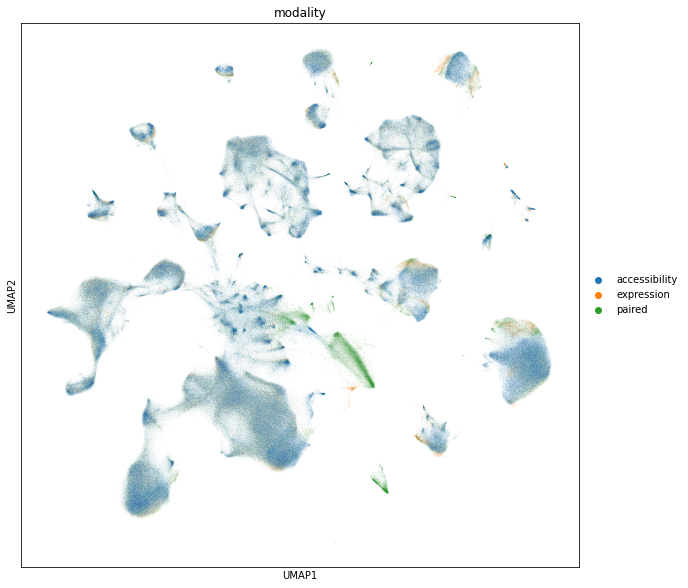

In [72]:
sc.pl.umap(adata_mvi, color='modality')

... storing 'Doublet_or_LowQuality' as categorical


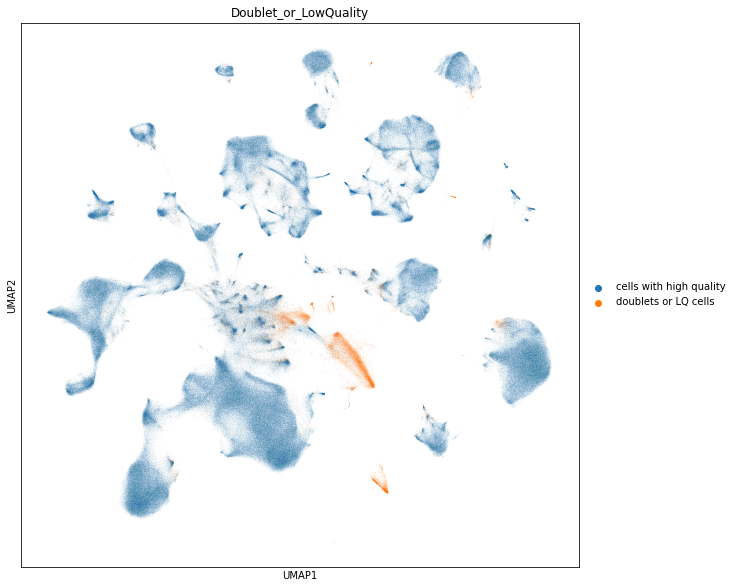

In [73]:
df = adata_mvi.obs
new_label = df["supertype_multiome_mask"].str.contains("_doublet") | df["supertype_multiome_mask"].str.contains("_LQ") | df["supertype_singleome_mask"].str.contains("_doublet") | df["supertype_singleome_mask"].str.contains("_LQ")
adata_mvi.obs["Doublet_or_LowQuality"] = np.where(new_label, "doublets or LQ cells", "cells with high quality")

sc.pl.umap(adata_mvi, color='Doublet_or_LowQuality')

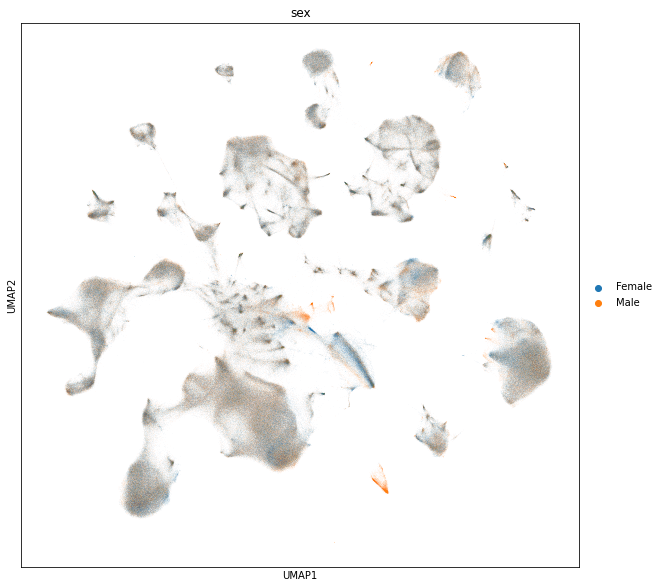

In [74]:
sc.pl.umap(adata_mvi, color='sex')

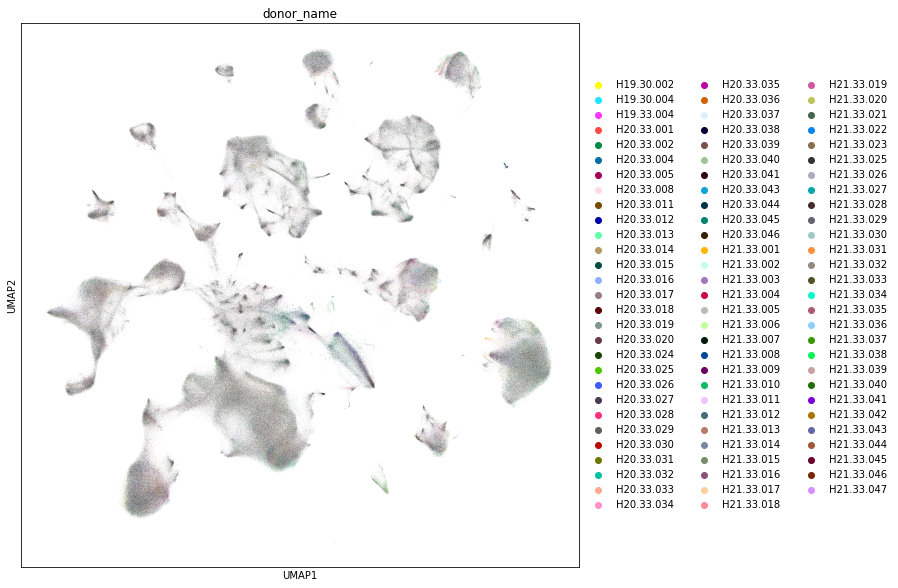

In [75]:
# plot based on donor names
sc.pl.umap(adata_mvi, color='donor_name')

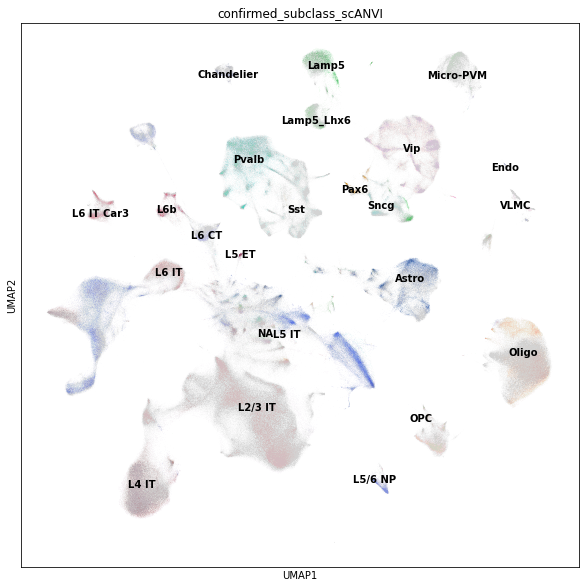

In [76]:
sc.pl.umap(adata_mvi, color='confirmed_subclass_scANVI', legend_loc="on data")

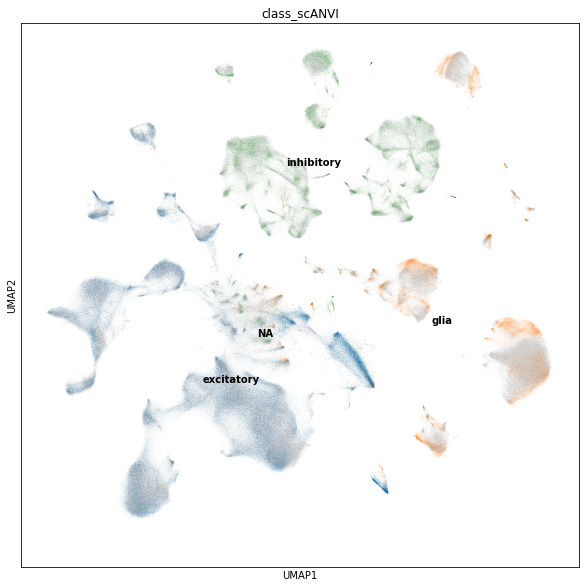

In [77]:
sc.pl.umap(adata_mvi, color='class_scANVI', legend_loc="on data")

In [100]:
adata_mvi.uns['neighbors']

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_MultiVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [166]:
idx = np.where(adata_mvi.uns['neighbors']['connectivities'][1].todense()>0)[1]

In [167]:
adata_mvi.uns['neighbors']['connectivities'][1, idx].todense()

matrix([[0.34633866, 0.14693536, 0.16456805, 0.13328715, 0.29871178,
         0.13756062, 0.63427967, 0.14381695, 0.19876538, 0.13198502,
         0.21772447, 0.34073502, 0.5535296 , 0.42917377, 0.18069263,
         0.67369837, 0.52542967, 0.39958626, 0.1475704 , 1.        ]],
       dtype=float32)

In [168]:
adata_mvi.obs['Doublet_or_LowQuality'][idx]

AGAACCAAGTGAGGGT-L8XR_210715_01_E12_paired    doublets or LQ cells
AGGATTGAGCTAATTG-L8XR_210729_01_C09_paired    doublets or LQ cells
CAAACTGGTTTATTCG-L8XR_210729_01_C09_paired    doublets or LQ cells
CAGGACACATTGCAGC-L8XR_210715_01_E12_paired    doublets or LQ cells
CATAGTCAGCTAAAGG-L8XR_210729_01_C09_paired    doublets or LQ cells
CGATTATCAGCAAGAT-L8XR_210729_01_C09_paired    doublets or LQ cells
GACGCAACAGTAGCCT-L8XR_210715_01_E12_paired    doublets or LQ cells
GAGCTTAGTCACAGCG-L8XR_210715_01_D12_paired    doublets or LQ cells
GAGTCAAAGGGTTATC-L8XR_210715_01_E12_paired    doublets or LQ cells
GCTTAAATCGATTTGA-L8XR_210715_01_E12_paired    doublets or LQ cells
GGATAACCACCTAATG-L8XR_210715_01_E12_paired    doublets or LQ cells
GGCCTAATCATGAAGG-L8XR_210715_01_E12_paired    doublets or LQ cells
GTGCATTAGCGGATAA-L8XR_210715_01_E12_paired    doublets or LQ cells
GTTACGCCACCTGTAA-L8XR_210715_01_E12_paired    doublets or LQ cells
GTTGCGGGTGGTGAGA-L8XR_210729_01_E09_paired    doublets or LQ c

In [169]:
adata_mvi.obs[["Doublet_or_LowQuality", "modality"]].iloc[idx]

,Doublet_or_LowQuality,modality
AGAACCAAGTGAGGGT-L8XR_210715_01_E12_paired,doublets or LQ cells,paired
AGGATTGAGCTAATTG-L8XR_210729_01_C09_paired,doublets or LQ cells,paired
CAAACTGGTTTATTCG-L8XR_210729_01_C09_paired,doublets or LQ cells,paired
CAGGACACATTGCAGC-L8XR_210715_01_E12_paired,doublets or LQ cells,paired
CATAGTCAGCTAAAGG-L8XR_210729_01_C09_paired,doublets or LQ cells,paired
CGATTATCAGCAAGAT-L8XR_210729_01_C09_paired,doublets or LQ cells,paired
GACGCAACAGTAGCCT-L8XR_210715_01_E12_paired,doublets or LQ cells,paired
GAGCTTAGTCACAGCG-L8XR_210715_01_D12_paired,doublets or LQ cells,paired
GAGTCAAAGGGTTATC-L8XR_210715_01_E12_paired,doublets or LQ cells,paired
GCTTAAATCGATTTGA-L8XR_210715_01_E12_paired,doublets or LQ cells,paired


In [162]:
def compute_cell_quality(adata_mvi, cell_idx):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[["Doublet_or_LowQuality", "modality"]].iloc[idx]
    df = df.loc[df["modality"].isin(["paired", "expression"])]
    ratio = np.sum(df["Doublet_or_LowQuality"] == "doublets or LQ cells") / df["Doublet_or_LowQuality"].shape[0]
    return ratio


In [163]:
cells = adata_mvi.uns['neighbors']['connectivities'].shape[0]

In [173]:
cells

1253610

In [164]:
qc_ratios = np.zeros(cells)
for i in np.arange(cells):
    ratio = compute_cell_quality(adata_mvi, i)
    qc_ratios[i] = ratio

In [172]:
qc_ratios

array([0.09090909, 1.        , 0.04166667, ..., 0.        ,        nan,
       0.16666667])

In [170]:
adata_mvi.obs["rna_neighbors_qc_ratio"] = qc_ratios

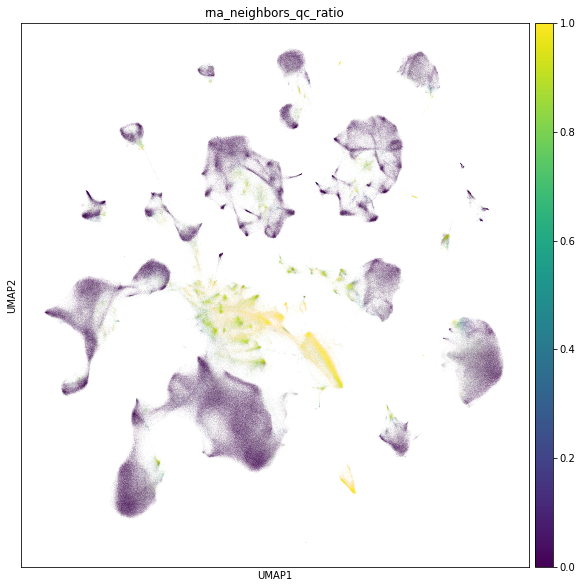

In [171]:
sc.pl.umap(adata_mvi, color="rna_neighbors_qc_ratio")

(array([6.71982e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 7.00000e+00, 2.70000e+01, 4.40000e+01,
        1.18000e+02, 2.00000e+02, 2.86000e+02, 4.32000e+02, 4.61000e+02,
        6.10000e+02, 8.31000e+02, 1.06100e+03, 6.86000e+02, 8.43000e+02,
        2.12200e+03, 1.32300e+03, 1.48200e+03, 1.74900e+03, 2.10000e+01,
        2.10100e+03, 2.19500e+03, 2.51400e+03, 6.70000e+01, 2.73400e+03,
        9.20000e+01, 2.86200e+03, 1.29000e+02, 3.04800e+03, 1.54000e+02,
        2.90400e+03, 1.20000e+01, 2.42000e+02, 2.29600e+03, 2.80000e+01,
        3.32000e+02, 2.20000e+03, 3.40000e+01, 4.45000e+02, 4.40000e+01,
        2.31100e+03, 6.30000e+01, 5.61000e+02, 7.30000e+01, 1.00000e+00,
        2.47700e+03, 8.20000e+01, 7.33000e+02, 1.20000e+02, 1.90000e+01,
        2.72200e+03, 2.00000e+00, 1.33000e+02, 9.60000e+02, 5.00000e+00,
        1.65000e+02, 1.00000e+00, 2.86700e+03, 0.00000e+00, 4.00000e+01,
        2.37000e+02, 9.50000e+02, 8.00000e+00, 2.97

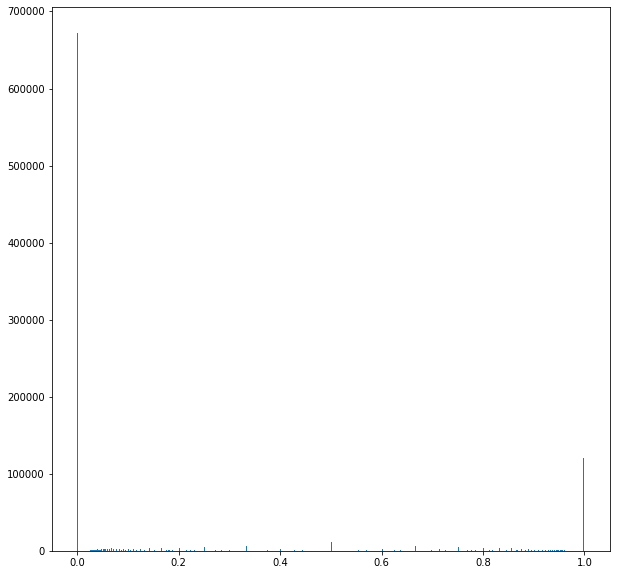

In [18]:
plt.hist(adata_mvi.obs["rna_neighbors_qc_ratio"], 500)

In [ ]:
### this is a function provided by Mariano and found online. 
# from sklearn.neighbors import kneighbors_graph

# def compute_batch_mixing(latent, batch_id, k):
#     nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
#     batch_id = pd.Categorical(batch_id).codes
#     self_id = batch_id[nng.row]
#     ne_id = batch_id[nng.col]
   
#     _, c = np.unique(batch_id, return_counts=True)
#     theoretic_score = ((c / c.sum()) ** 2).sum()
#     return (self_id == ne_id).mean() / theoretic_score

In [195]:
label = adata_mvi.obs['modality']
# label: paired, accessibility or expression

_, c = np.unique(label, return_counts=True)
theoretic_score = ((c / c.sum()) ** 2).sum()

In [196]:
def compute_cell_mixing(adata_mvi, cell_idx):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[["modality"]].iloc[idx]
    ratio = np.sum(df["modality"] == adata_mvi.obs["modality"][cell_idx]) / df["modality"].shape[0]
    return ratio / theoretic_score

In [213]:
modality_mixing = np.zeros(cells)
for i in np.arange(cells):
    ratio = compute_cell_mixing(adata_mvi, i)
    modality_mixing[i] = ratio

In [279]:
adata_mvi.obs["modality_mixing_ratio"] = modality_mixing

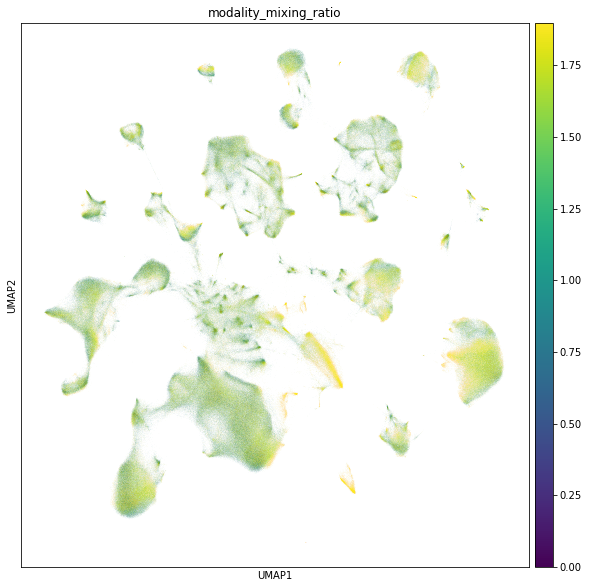

In [280]:
sc.pl.umap(adata_mvi, color='modality_mixing_ratio')

In [30]:
def compute_label_purity(adata_mvi, cell_idx):
    idx = np.where(adata_mvi.uns['neighbors']['connectivities'][cell_idx].todense()>0)[1]
    df = adata_mvi.obs[["confirmed_subclass_scANVI"]].iloc[idx]
    df = df.loc[~df["confirmed_subclass_scANVI"].isnull()]
    u, c = np.unique(df, return_counts=True)
    if np.size(c) == 0:
        ratio = 0
        label = 'NA'
    else:
        ratio = c[np.argmax(c)] / c.sum()
        label = u[np.argmax(c)]
    
    return ratio, label

In [34]:
cells = adata_mvi.shape[0]
purity_ratios = np.zeros(cells)
labels = adata_mvi.obs['confirmed_subclass_scANVI'].to_numpy()
for i in np.arange(cells):
    ratio, label_ = compute_label_purity(adata_mvi, i)
    purity_ratios[i] = ratio
    labels[i] = label_

In [36]:
adata_mvi.obs["subclass_purity_ratio"] = purity_ratios
adata_mvi.obs["label_transfer"] = labels
# ad = adata_mvi[adata_mvi.obs["rna_neighbors_qc_ratio"].to_numpy() < 0.01].copy()

... storing 'label_transfer' as categorical


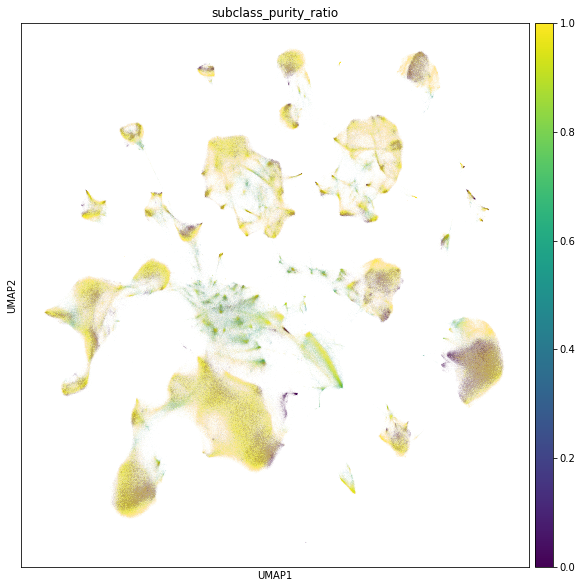

In [37]:
sc.pl.umap(adata_mvi, color='subclass_purity_ratio')

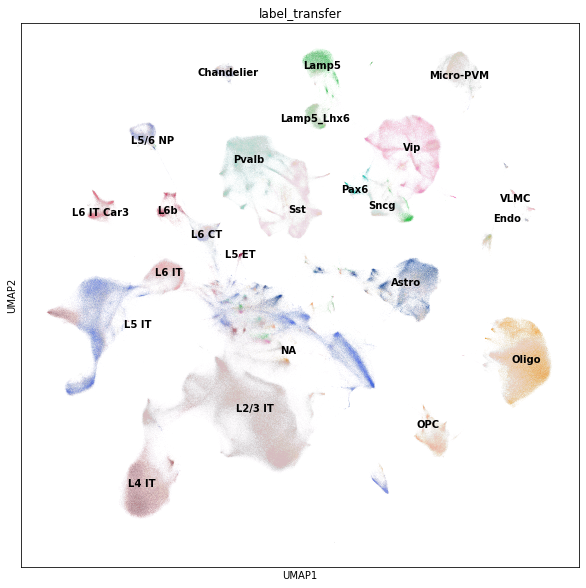

In [39]:
sc.pl.umap(adata_mvi, color='label_transfer', legend_loc="on data")

In [40]:
adata_mvi.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_trained_addQC.h5ad")

### Filter adata_mvi based on QC ratios and plot metadata

In [1]:
import os
import warnings
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")

pwd = os.getcwd()

plt.rcParams["figure.figsize"] = (10, 10)

Global seed set to 0


In [2]:
adata_mvi = anndata.read_h5ad(filename="multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.2_trained_addQC.h5ad")

In [3]:
ad = adata_mvi[adata_mvi.obs["rna_neighbors_qc_ratio"].to_numpy() < 0.01].copy()

In [4]:
del adata_mvi

In [5]:
ad.obs.subclass_purity_ratio.min()

0.3333333333333333

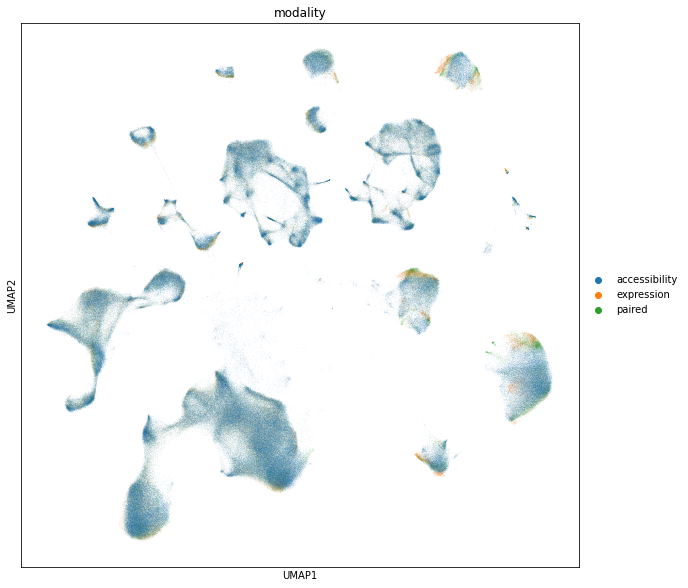

In [6]:
sc.pl.umap(ad, color='modality')

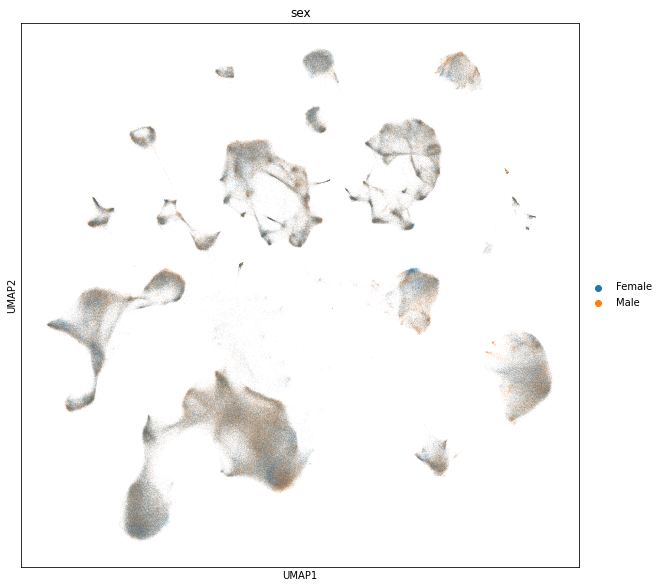

In [7]:
sc.pl.umap(ad, color='sex')

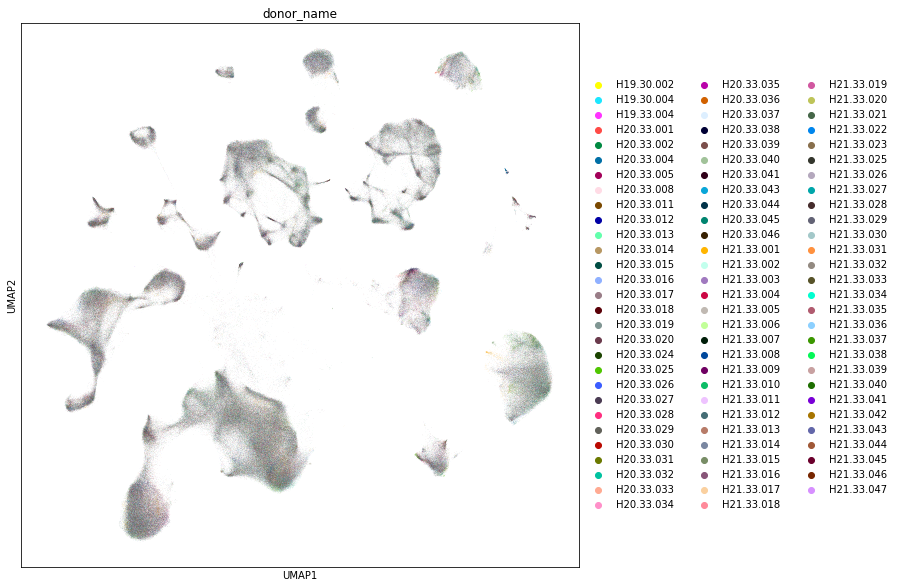

In [8]:
sc.pl.umap(ad, color='donor_name')

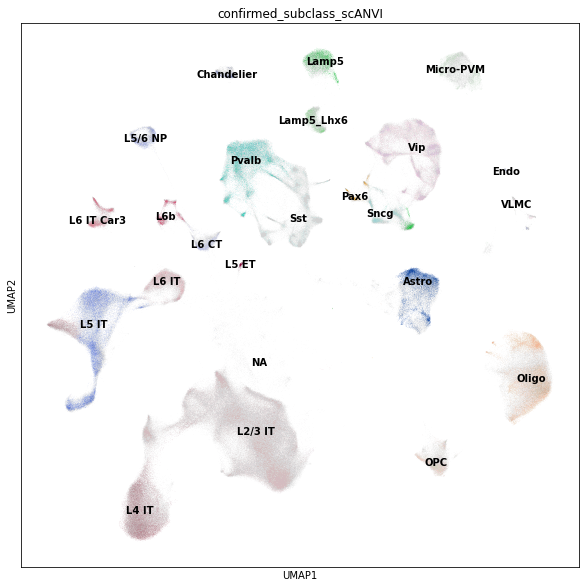

In [9]:
sc.pl.umap(ad, color='confirmed_subclass_scANVI', legend_loc="on data")

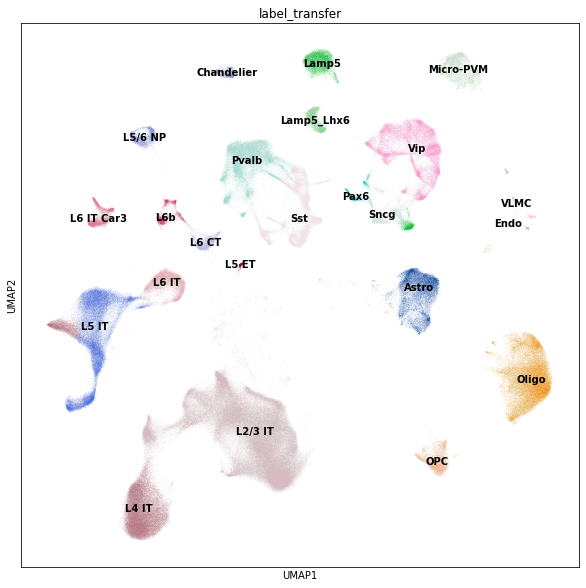

In [10]:
sc.pl.umap(ad, color='label_transfer', legend_loc="on data")

In [11]:
df = ad.obs[["confirmed_subclass_scANVI", "label_transfer", "modality"]]
df = df[df["modality"].isin(["paired", "expression"])]
print(np.sum(df["confirmed_subclass_scANVI"] == df["label_transfer"]))
print(df.shape)
print(226771/228013)

226771
(228013, 3)
0.9945529421568069


In [12]:
b = np.array(ad.obs['sample_id'].str.split("-", expand=True))

In [13]:
ad.obs['barcodes_out'] = b[:, 0] + "-1"

In [28]:
atac_only_anno = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/ATAC-Seq/Arrow/ATAC_AD_Center_Grant_complete/ATAC_AD_Center_Grant_complete.csv")

In [29]:
atac_only_anno = atac_only_anno.loc[:, ['library_prep', 'ar_directory', 'ar_id']]

In [30]:
atac_only_anno["path_to_fragments"] = atac_only_anno["ar_directory"] + atac_only_anno["ar_id"].astype(str) + "/outs/fragments.tsv.gz"

In [31]:
atac_only_anno.iloc[:3,]

,library_prep,ar_directory,ar_id,path_to_fragments
0,L8AT_211117_01_G07,/allen/programs/celltypes/production/mousecell...,1143360947,/allen/programs/celltypes/production/mousecell...
1,L8AT_211117_01_H07,/allen/programs/celltypes/production/mousecell...,1143360948,/allen/programs/celltypes/production/mousecell...
2,L8AT_211117_01_A08,/allen/programs/celltypes/production/mousecell...,1143360949,/allen/programs/celltypes/production/mousecell...


In [32]:
mult_only_anno = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/10x/ARC/Human/ARC_AD_Center_Grant_MTG/ARC_AD_Center_Grant_MTG_MTX-2036_human.csv")

In [33]:
mult_only_anno = mult_only_anno.loc[:, ['library_prep', 'ar_directory', 'ar_id']]

In [34]:
mult_only_anno["path_to_fragments"] = mult_only_anno["ar_directory"] + mult_only_anno["ar_id"].astype(str) + "/outs/atac_fragments.tsv.gz"

In [35]:
mult_only_anno.iloc[:3,]

,library_prep,ar_directory,ar_id,path_to_fragments
0,L8XR_210429_01_H05,/allen/programs/celltypes/production/mousecell...,1121324437,/allen/programs/celltypes/production/mousecell...
1,L8XR_210429_01_A06,/allen/programs/celltypes/production/mousecell...,1121324439,/allen/programs/celltypes/production/mousecell...
2,L8XR_210715_01_D12,/allen/programs/celltypes/production/mousecell...,1121747486,/allen/programs/celltypes/production/mousecell...


In [36]:
atac_anno = pd.concat([mult_only_anno, atac_only_anno])

In [38]:
atac_anno

,library_prep,ar_directory,ar_id,path_to_fragments
0,L8XR_210429_01_H05,/allen/programs/celltypes/production/mousecell...,1121324437,/allen/programs/celltypes/production/mousecell...
1,L8XR_210429_01_A06,/allen/programs/celltypes/production/mousecell...,1121324439,/allen/programs/celltypes/production/mousecell...
2,L8XR_210715_01_D12,/allen/programs/celltypes/production/mousecell...,1121747486,/allen/programs/celltypes/production/mousecell...
3,L8XR_210715_01_E12,/allen/programs/celltypes/production/mousecell...,1121747487,/allen/programs/celltypes/production/mousecell...
4,L8XR_210715_01_A12,/allen/programs/celltypes/production/mousecell...,1121939868,/allen/programs/celltypes/production/mousecell...
...,...,...,...,...
97,L8AT_210427_01_B05,/allen/programs/celltypes/production/mousecell...,1104418819,/allen/programs/celltypes/production/mousecell...
98,L8AT_220126_01_B09,/allen/programs/celltypes/production/mousecell...,1158586576,/allen/programs/celltypes/production/mousecell...
99,L8AT_220126_01_C09,/allen/programs/celltypes/production/mousecell...,1158586577,/allen/programs/celltypes/production/mousecell...
100,L8AT_220126_01_D09,/allen/programs/celltypes/production/mousecell...,1158586578,/allen/programs/celltypes/production/mousecell...


In [39]:
df = ad.obs
print(df.shape)
df1 = df.reset_index(inplace=False)

(671982, 649)


In [40]:
print(df1.shape)
df_new = pd.merge(df1, atac_anno, how='left', on='library_prep')
print(df_new.shape)

(671982, 650)
(671982, 653)


In [41]:
# to test if left join keeps original left df order.
print("barcode orders that mismatch between original and joined dataframes: ", sum(df_new.level_0 != df1.level_0))
print("barcode orders that match between original and joined dataframes: ", sum(df_new.level_0 == df1.level_0))

barcode orders that mismatch between original and joined dataframes:  0
barcode orders that match between original and joined dataframes:  671982


In [42]:
df_new.set_index("level_0", inplace=True)

In [43]:
df_new.index.name = None

In [44]:
np.sum(df.index != df_new.index)

0

In [45]:
ad.obs = df_new

In [46]:
ad.obs[["path_to_fragments", "label_transfer", "barcodes_out"]]

,path_to_fragments,label_transfer,barcodes_out
AAACAGCCAAAGCTCC-L8XR_211007_02_C04_paired,/allen/programs/celltypes/production/mousecell...,L5 IT,AAACAGCCAAAGCTCC-1
AAACAGCCAAATATCC-L8XR_210729_01_D09_paired,/allen/programs/celltypes/production/mousecell...,Pvalb,AAACAGCCAAATATCC-1
AAACAGCCAACAACAA-L8XR_210902_02_B08_paired,/allen/programs/celltypes/production/mousecell...,Micro-PVM,AAACAGCCAACAACAA-1
AAACAGCCAACACTTG-L8XR_210902_02_D08_paired,/allen/programs/celltypes/production/mousecell...,Astro,AAACAGCCAACACTTG-1
AAACAGCCAACAGCCT-L8XR_210729_01_E09_paired,/allen/programs/celltypes/production/mousecell...,L4 IT,AAACAGCCAACAGCCT-1
...,...,...,...
TTTGGTTGTTATGCAC-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,Lamp5,TTTGGTTGTTATGCAC-1
TTTGTGTCAAGTTCGT-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,Pvalb,TTTGTGTCAAGTTCGT-1
TTTGTGTCAGGCATTT-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,L4 IT,TTTGTGTCAGGCATTT-1
TTTGTGTGTTACCCAA-L8AT_211117_01_F07_accessibility,/allen/programs/celltypes/production/mousecell...,L6b,TTTGTGTGTTACCCAA-1


In [47]:
ad.write("multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.3_trained.h5ad")

... storing 'library_prep' as categorical
... storing 'barcodes_out' as categorical
... storing 'ar_directory_y' as categorical
... storing 'path_to_fragments' as categorical


In [ ]:
# ad = anndata.read_h5ad(filename="multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.3_trained.h5ad")

### Some manipulation and test output

In [1]:
import os
import warnings
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")

pwd = os.getcwd()

plt.rcParams["figure.figsize"] = (10, 10)

Global seed set to 0


In [2]:
ad = anndata.read_h5ad(filename="multivi_AD_3cohorts_RNA_ATAC_Multiome_v1.3_trained.h5ad")

In [48]:
ad.obs.barcodes_out.nunique()

548357

In [49]:
ad.obs.barcodes_out.shape

(671982,)

In [50]:
df = ad.obs[["path_to_fragments", "label_transfer", "barcodes_out", "library_prep", "modality"]]
df1 = df[df.label_transfer == "Endo"]

In [51]:
df1 = df1.astype('str')

In [52]:
df1.dtypes

path_to_fragments    object
label_transfer       object
barcodes_out         object
library_prep         object
modality             object
dtype: object

In [53]:
df_s = df1[df1.modality == "accessibility"]
df_m = df1[df1.modality == "expression"]

In [54]:
print(df1.barcodes_out.nunique())
print(df1.barcodes_out.shape)

935
(935,)


In [55]:
df_s.shape

(448, 5)

In [56]:
df_m.shape

(307, 5)

In [57]:
df_s.library_prep.nunique()

96

In [58]:
df_s_ls = [x for _, x in df_s.groupby("library_prep", as_index=False)]

In [59]:
df_s.groupby("library_prep").size()

library_prep
L4AT_201012_01_B04     3
L4AT_201012_01_D04     2
L4AT_201019_01_E04     1
L4AT_201019_01_F04     1
L4AT_201019_01_G04     1
                      ..
L8AT_220112_01_G03     1
L8AT_220112_01_H03     1
L8AT_220126_01_B09     1
L8AT_220126_01_C09     3
L8AT_220126_01_D09    13
Length: 96, dtype: int64

In [60]:
#ans = [y for x, y in DF.groupby('chr', as_index=False)]
#[x for _, x in df.groupby(df['Sales'] < 30)]
df_s_ls = [x for _, x in df_s.groupby("library_prep")]

In [61]:
len(df_s_ls)

96